# Trabajo Práctico: Extracción de Petróleo 🛢️

Este notebook implementa la resolución de una ecuación diferencial ordinaria (EDO) que modela el perfil de temperatura radial en una tubería de extracción de petróleo de alta presión y temperatura.

Se resuelve el siguiente problema de valor en la frontera:


$$
r \cdot \frac{d^2T}{dr^2} + \frac{dT}{dr} = 0
$$



Con condiciones de borde (padrón 110616):

- $$ T(r_1) = T_1 = 406^\circ C $$
- $$ T(r_2) = T_2 = 16^\circ C $$

Usaremos el **método del tiro** junto con **Euler** para resolverlo numéricamente.


## ctes:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema

R1 = 101.6  # mm
R2 = 113.6  # mm

T1 = 406    # °C
T2 = 16    # °C

S1 = -100 # valor inicial del primer tiro
S2 = -1 # valor inicial del segundo tiro

h = 1.0 #paso de 1 mm

resultados = {}

## Método del Tiro 🎯




In [2]:
def u_real(r):
    A = (T1 - T2) / (np.log(R1) - np.log(R2))
    B = T1 - A * np.log(R1)
    return A * np.log(r) + B


In [3]:
def derivada_exacta_r1(T1, T2, r1, r2):
    return -(T1 - T2) / (np.log(r2 / r1) * r1)
print(derivada_exacta_r1(T1, T2, R1, R2))

-34.38358714962284


In [4]:
# Solución exacta para comparar
def T_exacta(r):
    return (T1 - T2) * np.log(R2 / r) / np.log(R2 / R1) + T2

def metodo_del_tiro(h, func):
    s1, s2 = S1, S2  # valores iniciales tentativos

    r, u1 = func(s1, h)
    resultados["euler_explicito_tiro_1"] = (r, u1)
    r, u2 = func(s2, h)
    resultados["euler_explicito_tiro_2"] = (r, u2)

    # Interpolación lineal (una sola vez)
    s_new = s2 + ((s1-s2)/(u1[-1] - u2[-1])) * (T2-u2[-1])

    #print(f"\n Derivada inicial interpolada: {s_new:.6f}")

    # Ejecutar Euler una sola vez con la derivada corregida
    r, u3 = func(s_new, h)

    resultados["euler_explicito_tiro_3"] = (r, u3)



    return r, u3, s_new


def imprimir_resultados_metodo_del_tiro(r, u3, s_new):

    print(f"{2:9d} | {s_new:8.4f} | {u3[-1]:11.6f} | {abs(u3[-1] - T2):.6f}")

    print(f"\nError final real: {abs(u3[-1] - T2):.12f}")

    errores = []
    # Mostrar error en cada paso comparado con solución exacta
    print("\n📈 Errores punto a punto respecto a la solución exacta:")
    print("Paso | r        | u_num      | u_exact    | Error")
    print("------------------------------------------------------")
    for i in range(len(r)):
        r_i = r[i]
        u_i = u3[i]
        u_ex = u_real(r_i)
        error = abs(u_i - u_ex)
        errores.append(round(error, 6))
        print(f"{i:4d} | {r_i:8.2f} | {u_i:10.6f} | {u_ex:10.6f} | {error:8.6f}")


    print("lista de errores: ", errores)



In [5]:
def tolerance_reduction(h_max, func, tolerance, max_iterations=20):
    """
    Encuentra el valor más grande de h en [h_min, h_max] tal que el error máximo sea <= tolerance.
    Usa búsqueda binaria.
    """
    iter_count = 0
    h_opt = h_max  # Lo inicializamos en el máximo
    h_min = 0


    r, u, s_final = metodo_del_tiro(h_max, func)
    errores = [abs(u[i] - u_real(r[i])) for i in range(len(r))]
    error_max = max(errores)
    if error_max < tolerance:
        imprimir_resultados_metodo_del_tiro(r, u, s_final)
        return



    while (h_max - h_min) > 1e-6 and iter_count < max_iterations:
        h_mid = round(((h_min + h_max) / 2.0), 4)
        print(f"\n=== Ejecutando con h = {h_mid:.20f} mm ===")
        r, u, s_final = metodo_del_tiro(h_mid, func)
        if r[-1] > R2:
            r[-1] = R2

        errores = [abs(u[i] - u_real(r[i])) for i in range(len(r))]
        error_max = max(errores)

        print(f"Máximo error punto a punto: {error_max:.6f} °C")

        if error_max < tolerance:
            # Puede que haya uno más grande que también cumpla la condición
            h_min = h_mid
            h_opt = h_mid
        else:
            # Demasiado grande, reducir
            h_max = h_mid

        iter_count += 1




    print(f"\nPaso final elegido: {h_opt:.20f} mm con error máximo de {error_max:.6f} °C y derivada final: {s_final:.6f}")
    r, u, s_final = metodo_del_tiro(h_opt, func)
    imprimir_resultados_metodo_del_tiro(r, u, s_final)


## Euler Explicito

### codigo


In [6]:
def euler_system(s, h):
    r = R1
    u = T1
    v = s

    r_values = [r]
    u_values = [u]
    v_values = [v]

    while r < R2:
        u = u + h * v
        v = v + h * (-v / r)
        r += h

        r_values.append(r)
        u_values.append(u)
        v_values.append(v)

    # Imprimir errores respecto a solución exacta
    #print("\nPaso | r        | u_num      | u_exact    | Error")
    #print("------------------------------------------------------")
    for i in range(len(r_values)):
        r_i = r_values[i]
        u_i = u_values[i]
        u_exact = u_real(r_i)
        error = abs(u_i - u_exact)
        #print(f"{i:4d} | {r_i:8.2f} | {u_i:10.4f} | {u_exact:10.4f} | {error:8.4f}")

    return np.array(r_values), np.array(u_values)
#euler_system(-34.38358714962284,1)


### Resultados y comparación con solución exacta

Graficamos la solución obtenida por Euler y la solución exacta:


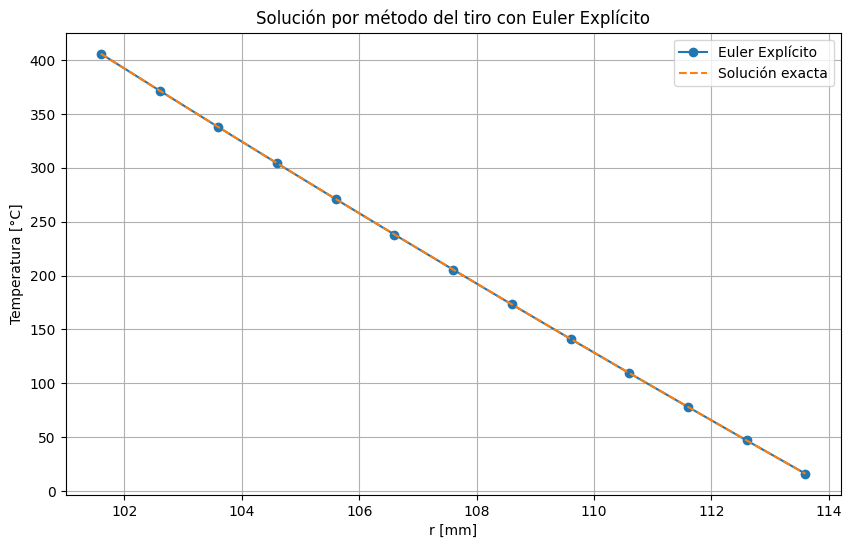

Derivada inicial encontrada (s): -34.2405240298
Error final: 0.0000000000 °C
        2 | -34.2405 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 | 406.000000 | 406.000000 | 0.000000
   1 |   102.60 | 371.759476 | 371.784521 | 0.025045
   2 |   103.60 | 337.855965 | 337.900915 | 0.044950
   3 |   104.60 | 304.282898 | 304.342804 | 0.059906
   4 |   105.60 | 271.033894 | 271.103995 | 0.070101
   5 |   106.60 | 238.102760 | 238.178469 | 0.075710
   6 |   107.60 | 205.483472 | 205.560375 | 0.076903
   7 |   108.60 | 173.170182 | 173.244026 | 0.073844
   8 |   109.60 | 141.157202 | 141.223889 | 0.066688
   9 |   110.60 | 109.439000 | 109.494584 | 0.055584
  10 |   111.60 |  78.010198 |  78.050876 | 0.040678
  11 |   112.60 |  46.865562 |  46.887668 | 0.022106
  12 |   113.60 |  16.000000 |  16.000000 | 0.

In [7]:
r_vals, u_vals, s_final = metodo_del_tiro(h, euler_system)
r_exacto = np.linspace(R1, R2, 300)
T_exacto = T_exacta(r_exacto)
resultados["euler_solucion_exacta"] = (r_exacto, T_exacta)



# Graficamos
plt.figure(figsize=(10, 6))  # Aumenta el tamaño de la figura (ancho x alto en pulgadas)
plt.plot(r_vals, u_vals, 'o-', label='Euler Explícito')
plt.plot(r_exacto, T_exacto, '--', label='Solución exacta')
plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Solución por método del tiro con Euler Explícito')
plt.legend()
plt.grid()
plt.show()

print(f"Derivada inicial encontrada (s): {s_final:.10f}")
print(f"Error final: {abs(u_vals[-1] - T2):.10f} °C")

imprimir_resultados_metodo_del_tiro(r_vals, u_vals, s_final)




### más graficos

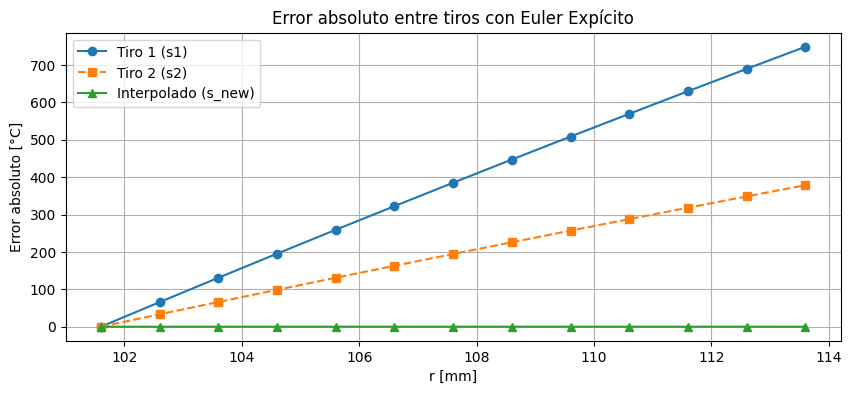

In [8]:
# Obtener los resultados de cada tiro
r1, u1 = resultados["euler_explicito_tiro_1"]
r2, u2 = resultados["euler_explicito_tiro_2"]
r3, u3 = resultados["euler_explicito_tiro_3"]
r_exacto, T_exacta = resultados["euler_solucion_exacta"]

# Interpolamos la solución exacta en los mismos puntos que u_vals
T_interp = T_exacta(r_vals)
error1 = np.abs(u1 - T_interp)
error2 = np.abs(u2 - T_interp)
error3 = np.abs(u3 - T_interp)



plt.figure(figsize=(10, 4))
plt.plot(r1, error1, 'o-', label='Tiro 1 (s1)')
plt.plot(r2, error2, 's--', label='Tiro 2 (s2)')
plt.plot(r3, error3,'^-', label='Interpolado (s_new)')

plt.xlabel('r [mm]')
plt.ylabel('Error absoluto [°C]')
plt.title('Error absoluto entre tiros con Euler Expícito')
plt.legend()
plt.grid()
plt.show()


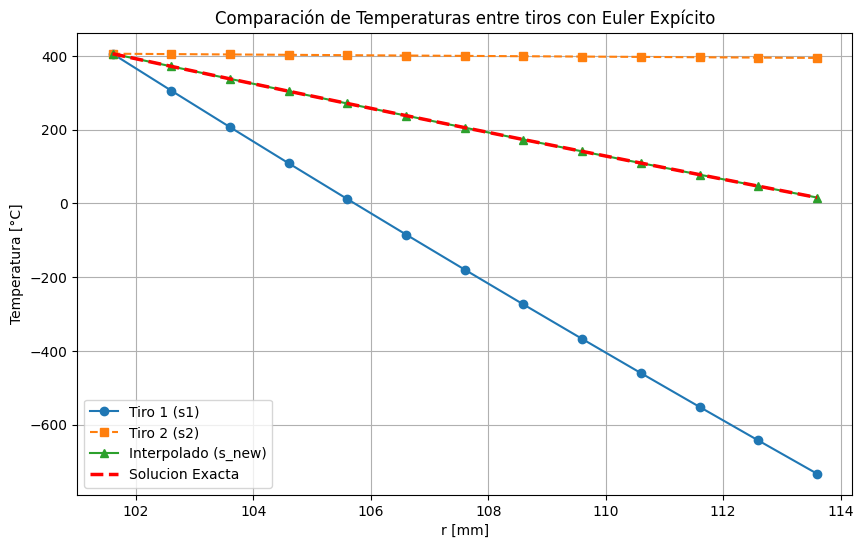

In [9]:
# Obtener los resultados de cada tiro
r1, u1 = resultados["euler_explicito_tiro_1"]
r2, u2 = resultados["euler_explicito_tiro_2"]
r3, u3 = resultados["euler_explicito_tiro_3"]

u_exacta = []
for r in r1:
    u_exacta.append(T_exacta(r))

#r_exacto, T_exacta = resultados["euler_solucion_exacta"]



plt.figure(figsize=(10, 6))
plt.plot(r1, u1, 'o-', label='Tiro 1 (s1)')
plt.plot(r2, u2, 's--', label='Tiro 2 (s2)')
plt.plot(r3, u3, '^-', label='Interpolado (s_new)')
plt.plot(r1, u_exacta, '--', label='Solucion Exacta', color='red',  linewidth=2.5)

plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Comparación de Temperaturas entre tiros con Euler Expícito')
plt.legend()
plt.grid()
plt.show()




### Tolerancia Euler Explicito < 0.02

In [10]:
tolerance_reduction(1, euler_system, 0.02)


=== Ejecutando con h = 0.50000000000000000000 mm ===
Máximo error punto a punto: 0.038202 °C

=== Ejecutando con h = 0.25000000000000000000 mm ===
Máximo error punto a punto: 0.019065 °C

=== Ejecutando con h = 0.37500000000000000000 mm ===
Máximo error punto a punto: 0.028626 °C

=== Ejecutando con h = 0.31250000000000000000 mm ===
Máximo error punto a punto: 5.619053 °C

=== Ejecutando con h = 0.28120000000000000551 mm ===
Máximo error punto a punto: 2.751866 °C

=== Ejecutando con h = 0.26560000000000000275 mm ===
Máximo error punto a punto: 6.545959 °C

=== Ejecutando con h = 0.25779999999999997362 mm ===
Máximo error punto a punto: 3.510056 °C

=== Ejecutando con h = 0.25390000000000001457 mm ===
Máximo error punto a punto: 5.637035 °C

=== Ejecutando con h = 0.25200000000000000178 mm ===
Máximo error punto a punto: 2.891219 °C

=== Ejecutando con h = 0.25100000000000000089 mm ===
Máximo error punto a punto: 1.445184 °C

=== Ejecutando con h = 0.25050000000000000044 mm ===
Máximo

## Método de Euler Implícito

### Sistema de ecuaciones

Redefinimos la segunda orden como un sistema de primer orden usando:

- $$ u = T $$
- $$ v = \frac{du}{dr} = T' $$

Entonces:

$$
\begin{cases}
\frac{du}{dr} = v \\
\frac{dv}{dr} = -\frac{v}{r}
\end{cases}
$$


$$       
u_{n+1} = u_{n} + h \cdot v_{n+1}
$$
$$
v_{n+1} = v_{n} + h \cdot \left(-\frac{v_{n+1}}{r_{n+1}}\right)
$$

In [11]:
def euler_implicit(s, h):
    r = R1
    u = T1
    v = s

    r_values = [r]
    u_values = [u]
    v_values = [v]


    while r < R2:
        #print(r, u, v)
        r += h
        v = v / (1 + (h / r))
        u = u + h * v

        r_values.append(r)
        u_values.append(u)
        v_values.append(v)

    # Imprimir errores respecto a solución exacta
    #print("\nPaso | r        | u_num      | u_exact    | Error")
    #print("------------------------------------------------------")
    for i in range(len(r_values)):
        r_i = r_values[i]
        u_i = u_values[i]
        u_exact = u_real(r_i)
        error = abs(u_i - u_exact)
        #print(f"{i:4d} | {r_i:8.2f} | {u_i:10.4f} | {u_exact:10.4f} | {error:8.4f}")

    return np.array(r_values), np.array(u_values)
#euler_implicit(-34.38358714962284,1)
#euler_implicit(-1,1)

### Resultados y comparación con solución exacta

Graficamos la solución obtenida por Euler y la solución exacta:


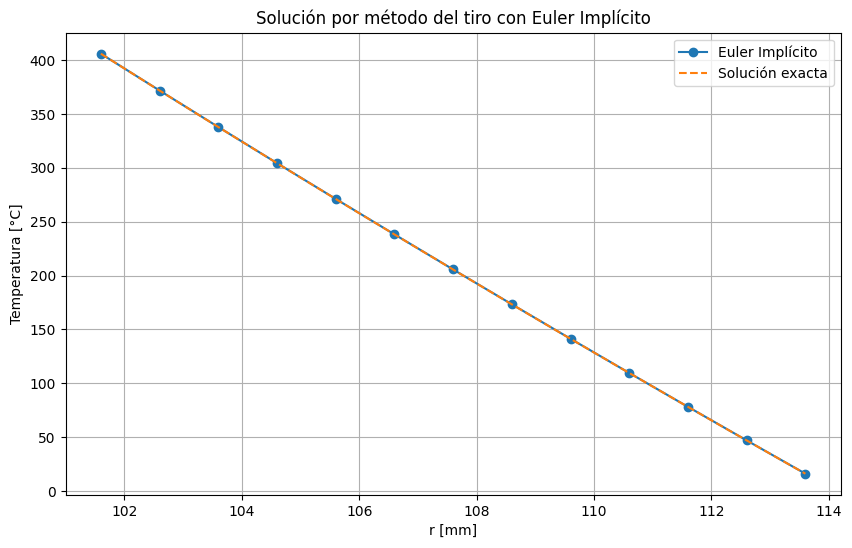

Derivada inicial encontrada (s): -34.5243404915
Error final: 0.0000000000 °C
        2 | -34.5243 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 | 406.000000 | 406.000000 | 0.000000
   1 |   102.60 | 371.808906 | 371.784521 | 0.024385
   2 |   103.60 | 337.944687 | 337.900915 | 0.043772
   3 |   104.60 | 304.401151 | 304.342804 | 0.058347
   4 |   105.60 | 271.172283 | 271.103995 | 0.068288
   5 |   106.60 | 238.252234 | 238.178469 | 0.073765
   6 |   107.60 | 205.635315 | 205.560375 | 0.074940
   7 |   108.60 | 173.315997 | 173.244026 | 0.071971
   8 |   109.60 | 141.288896 | 141.223889 | 0.065007
   9 |   110.60 | 109.548777 | 109.494584 | 0.054192
  10 |   111.60 |  78.090541 |  78.050876 | 0.039665
  11 |   112.60 |  46.909226 |  46.887668 | 0.021559
  12 |   113.60 |  16.000000 |  16.000000 | 0.

In [12]:
h = 1

r_vals, u_vals, s_final = metodo_del_tiro(h, euler_implicit)

# Solución exacta para comparar
def T_exacta(r):
    return (T1 - T2) * np.log(R2 / r) / np.log(R2 / R1) + T2

r_exacto = np.linspace(R1, R2, 300)
T_exacto = T_exacta(r_exacto)

# Graficamos
plt.figure(figsize=(10, 6))  # Aumenta el tamaño de la figura (ancho x alto en pulgadas)
plt.plot(r_vals, u_vals, 'o-', label='Euler Implícito')
plt.plot(r_exacto, T_exacto, '--', label='Solución exacta')
plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Solución por método del tiro con Euler Implícito')
plt.legend()
plt.grid()
plt.show()

print(f"Derivada inicial encontrada (s): {s_final:.10f}")
print(f"Error final: {abs(u_vals[-1] - T2):.10f} °C")

imprimir_resultados_metodo_del_tiro(r_vals, u_vals, s_final)




### Tolerancia

In [13]:
tolerance_reduction(1,euler_implicit, 0.02, 2)


=== Ejecutando con h = 0.50000000000000000000 mm ===
Máximo error punto a punto: 0.037711 °C

=== Ejecutando con h = 0.25000000000000000000 mm ===
Máximo error punto a punto: 0.018942 °C

Paso final elegido: 0.25000000000000000000 mm con error máximo de 0.018942 °C y derivada final: -34.418990
        2 | -34.4190 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 | 406.000000 | 406.000000 | 0.000000
   1 |   101.85 | 397.416322 | 397.414662 | 0.001660
   2 |   102.10 | 388.853610 | 388.850371 | 0.003239
   3 |   102.35 | 380.311763 | 380.307025 | 0.004738
   4 |   102.60 | 371.790678 | 371.784521 | 0.006157
   5 |   102.85 | 363.290256 | 363.282759 | 0.007497
   6 |   103.10 | 354.810396 | 354.801637 | 0.008759
   7 |   103.35 | 346.350999 | 346.341055 | 0.009944
   8 |   103.60 | 337.911966 | 337.9009

## RK2


### codigo

In [14]:
# Implementación de RK2 para el sistema
def rk2_system(s, h):
    r_values = [R1]
    u_values = [T1]
    v_values = [s]

    r = R1
    u = T1
    v = s

    while r < R2:
        q1u = h * v
        q1v = h* (-v / r)
        r = r + h
        
        q2u = h* (v + q1v)
        q2v = h* (-(v + q1v) / (r))
        
        u = u + ((q1u + q2u) / 2)
        v = v + ((q1v + q2v) / 2)

        r_values.append(r)
        u_values.append(u)
        v_values.append(v)




    err_max = 0

    # Imprimir errores respecto a solución exacta
    #print("\nPaso | r        | u_num      | u_exact    | Error")
    #print("------------------------------------------------------")
    for i in range(len(r_values)):
        r_i = r_values[i]
        u_i = u_values[i]
        u_exact = u_real(r_i)
        error = abs(u_i - u_exact)
        if error > err_max:
            err_max = error
        #print(f"{i:4d} | {r_i:8.2f} | {u_i:10.4f} | {u_exact:10.4f} | {error:8.4f}")



    #print("EEEEEEEEEEEEEEEERRROR MAX: ", err_max)
    return np.array(r_values), np.array(u_values)


#rk2_system(-34.38358714962284,1)


### Resultados

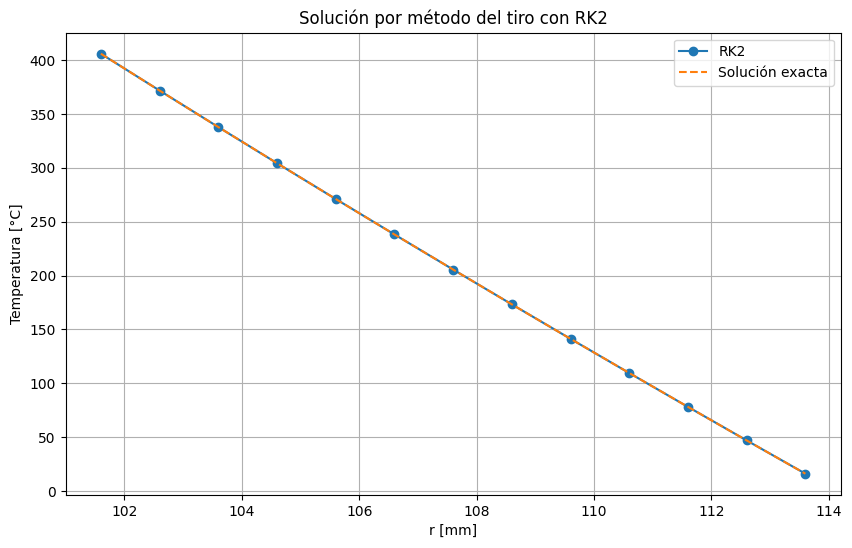

Derivada inicial encontrada (s): -34.3845892359
Error final: 0.0000000000 °C
Error max:  0.0003174249125379447
        2 | -34.3846 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 | 406.000000 | 406.000000 | 0.000000
   1 |   102.60 | 371.784626 | 371.784521 | 0.000105
   2 |   103.60 | 337.901103 | 337.900915 | 0.000188
   3 |   104.60 | 304.343054 | 304.342804 | 0.000250
   4 |   105.60 | 271.104286 | 271.103995 | 0.000291
   5 |   106.60 | 238.178783 | 238.178469 | 0.000313
   6 |   107.60 | 205.560693 | 205.560375 | 0.000317
   7 |   108.60 | 173.244330 | 173.244026 | 0.000304
   8 |   109.60 | 141.224163 | 141.223889 | 0.000274
   9 |   110.60 | 109.494812 | 109.494584 | 0.000227
  10 |   111.60 |  78.051042 |  78.050876 | 0.000166
  11 |   112.60 |  46.887758 |  46.887668 | 0.000090
  12 |   113

In [15]:
h = 1
r_vals, u_vals, s_final = metodo_del_tiro(h, rk2_system)



u_exacta = []
for r in r_vals:
    u_exacta.append(T_exacta(r))


r_exacto = np.linspace(R1, R2, 300)
T_exacto = T_exacta(r_exacto)

plt.figure(figsize=(10, 6))
plt.plot(r_vals, u_vals, 'o-', label='RK2')
plt.plot(r_vals, u_exacta, '--', label='Solución exacta')
plt.xlabel('r [mm]')
plt.ylabel('Temperatura [°C]')
plt.title('Solución por método del tiro con RK2')
plt.legend()
plt.grid()


plt.show()

print(f"Derivada inicial encontrada (s): {s_final:.10f}")
print(f"Error final: {abs(u_vals[-1] - T2):.10f} °C")
print(f'Error max: ', max([abs(u_val - u_e) for u_val, u_e in zip(u_vals, u_exacta)]))

imprimir_resultados_metodo_del_tiro(r_vals, u_vals, s_final)


### Cambio de paso h en RK2


In [16]:
tolerance_reduction(1, rk2_system, 0.02, 2)

        2 | -34.3846 |   16.000000 | 0.000000

Error final real: 0.000000000000

📈 Errores punto a punto respecto a la solución exacta:
Paso | r        | u_num      | u_exact    | Error
------------------------------------------------------
   0 |   101.60 | 406.000000 | 406.000000 | 0.000000
   1 |   102.60 | 371.784626 | 371.784521 | 0.000105
   2 |   103.60 | 337.901103 | 337.900915 | 0.000188
   3 |   104.60 | 304.343054 | 304.342804 | 0.000250
   4 |   105.60 | 271.104286 | 271.103995 | 0.000291
   5 |   106.60 | 238.178783 | 238.178469 | 0.000313
   6 |   107.60 | 205.560693 | 205.560375 | 0.000317
   7 |   108.60 | 173.244330 | 173.244026 | 0.000304
   8 |   109.60 | 141.224163 | 141.223889 | 0.000274
   9 |   110.60 | 109.494812 | 109.494584 | 0.000227
  10 |   111.60 |  78.051042 |  78.050876 | 0.000166
  11 |   112.60 |  46.887758 |  46.887668 | 0.000090
  12 |   113.60 |  16.000000 |  16.000000 | 0.000000
lista de errores:  [np.float64(0.0), np.float64(0.000105), np.float64(

## ERROR

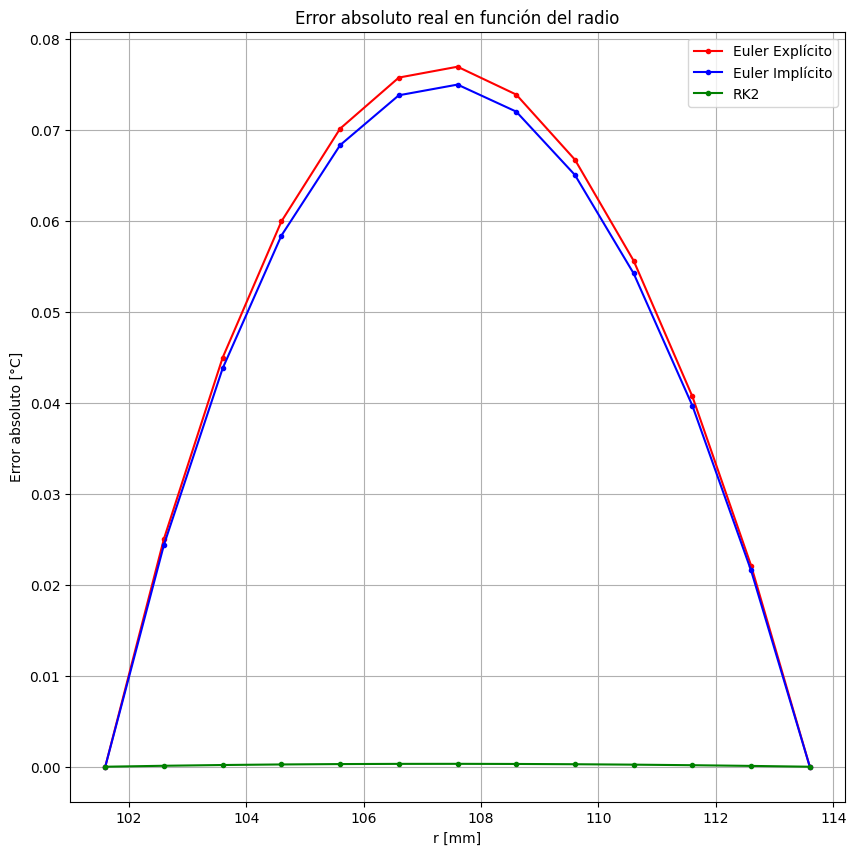

In [17]:

# Supongo que ya tienes los r_vals y u_vals de cada método calculados como:
r_vals_ee, u_vals_ee, _ = metodo_del_tiro(1, euler_system)
r_vals_ei, u_vals_ei, _  = metodo_del_tiro(1, euler_implicit)
r_vals_rk, u_vals_rk, _ =  metodo_del_tiro(1, rk2_system)
# y la solución exacta T_exacta

# Interpolamos la solución exacta en los mismos puntos de cada método
T_interp_ee = T_exacta(r_vals_ee)
T_interp_ei = T_exacta(r_vals_ei)
T_interp_rk = T_exacta(r_vals_rk)

# Calculamos el error absoluto para cada método
error_ee = np.abs(u_vals_ee - T_interp_ee)
error_ei = np.abs(u_vals_ei - T_interp_ei)
error_rk = np.abs(u_vals_rk - T_interp_rk)

plt.figure(figsize=(10, 10))

# Graficamos los errores de cada método con color y etiqueta
plt.plot(r_vals_ee, error_ee, 'r.-', label='Euler Explícito')
plt.plot(r_vals_ei, error_ei, 'b.-', label='Euler Implícito')
plt.plot(r_vals_rk, error_rk, 'g.-', label='RK2')

plt.xlabel('r [mm]')
plt.ylabel('Error absoluto [°C]')
plt.title('Error absoluto real en función del radio')
plt.grid()
plt.legend()  # Para que aparezcan las etiquetas
plt.show()
